plan：
1. train test split

## from here begin

In [2]:
# import utils
# import data
# import model

import numpy as np
import pandas as pd
import torch
import datetime
from sklearn import datasets
import scipy.sparse

import argparse
from tqdm import tqdm
import os
import pickle
import copy

In [3]:
from torch import nn, optim
import torch.nn.functional as F

# data processing

In [4]:
n_users, n_items = 6018, 3018
data_path = os.path.join(os.getcwd(), "Data/ml1m")

In [5]:
train_df = pd.read_csv(data_path + '/train_df.csv', dtype=np.int32)
item_warm = train_df['iid'].unique()

In [6]:
test_df = pd.read_csv(data_path+'/train_df.csv',dtype=np.int32)
item_warm = test_df['iid'].unique()

In [8]:
u_pref = np.load(data_path + '/U_emb_Heater.npy')
v_pref = np.load(data_path + '/I_emb_Heater.npy')
R = np.matmul(u_pref, v_pref.T).T

alpha = 4

R_train = scipy.sparse.coo_matrix((np.ones(len(train_df)),
                                              (train_df['iid'].values,
                                              train_df['uid'].values)),
                                             shape=(n_items, n_users)).tolil(copy=False)

R_test = scipy.sparse.coo_matrix((np.ones(len(test_df)),
                                              (test_df['iid'].values,
                                              test_df['uid'].values)),
                                             shape=(n_items, n_users)).tolil(copy=False)

#mask = R_train.toarray()
mask = R_test.toarray()
R = R - np.min(R)
R_output = R

pos_sum = np.sum(mask, axis=1, keepdims=True)
pos_mean = np.zeros_like(pos_sum)
pos_std = np.zeros_like(pos_sum)
pos_mean[item_warm, :] = np.sum(R_output[item_warm, :] * mask[item_warm, :], axis=1, keepdims=True) / pos_sum[item_warm, :]
pos_std[item_warm, :] = np.sum((R_output[item_warm, :] - pos_mean[item_warm, :]) ** 2 * mask[item_warm, :], axis=1, keepdims=True) / pos_sum[item_warm, :]
pos_mean = pos_mean ** alpha
weights = np.zeros_like(pos_sum)
weights[item_warm, :] = 0 + np.max(pos_mean[item_warm, :]) / pos_mean[item_warm, :]
#R_output = R_output * weights * mask + (1 - mask) * R_output


In [9]:
train = train_df.values.ravel().view(dtype=[('uid', np.int32), ('iid', np.int32)])
train

array([(   0,   2), (   0,   7), (   0,   8), ..., (6017, 147),
       (6017, 152), (6017,  26)], dtype=[('uid', '<i4'), ('iid', '<i4')])

use test set to see the overall performance of model, and use cold_test and cold_valid to see the performance on cold start scenario

In [18]:
test = test_df.values.ravel().view(dtype=[('uid', np.int32), ('iid', np.int32)])
test

array([(   0,   2), (   0,   7), (   0,   8), ..., (6017, 147),
       (6017, 152), (6017,  26)], dtype=[('uid', '<i4'), ('iid', '<i4')])

In [23]:
cold_test = pd.read_csv(data_path + '/cold_test_df.csv', dtype=np.int32).values.ravel().view(dtype=[('uid', np.int32),
                                                                                    ('iid', np.int32)])
cold_vali = pd.read_csv(data_path + '/cold_vali_df.csv', dtype=np.int32).values.ravel().view(dtype=[('uid', np.int32),
                                                                                    ('iid', np.int32)])


In [19]:
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataloader import default_collate

# Convert your data to PyTorch tensors
R_tensor = torch.tensor(R, dtype=torch.float32)
R_output_tensor = torch.tensor(R_output, dtype=torch.float32)

# Create a dataset where both the input and the target are R (since it's an autoencoder)
dataset = TensorDataset(R_tensor, R_output_tensor)
def custom_collate_fn(batch):
    return torch.stack(batch) 


#train_loader = DataLoader(dataset, batch_size=50, shuffle=True, collate_fn=default_collate)
test_loader = DataLoader(dataset, batch_size=50, shuffle=True, collate_fn=default_collate)


# model

In [11]:
class AutoEncoder(nn.Module):
    def __init__(self, layer_sizes, use_batch_norm=False):
        super(AutoEncoder, self).__init__()
        self.layers = nn.ModuleList()
        self.use_batch_norm = use_batch_norm
        self.batch_norms = nn.ModuleList()

        # Setup layers
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if use_batch_norm and i < len(layer_sizes) - 1:
                self.batch_norms.append(nn.BatchNorm1d(layer_sizes[i + 1]))

    def forward(self, x):
        x = x.view(-1, 6018)
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if self.use_batch_norm and i < len(self.layers) - 1:
                x = self.batch_norms[i](x)
            if i < len(self.layers) - 1:
                x = torch.relu(x)
        return x



    def get_regularization_loss(self):
        reg_loss = 0.0
        for layer in self.layers:
            reg_loss += torch.norm(layer.weight, p=2) + torch.norm(layer.bias, p=2)
        return reg_loss


In [12]:
class DistributionGenerator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DistributionGenerator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, output_dim)
        )

    def forward(self, x):
        return self.layers(x)



In [13]:
def gaussian_kernel(x, y, sigma=1.0):
    """
    Computes the Gaussian kernel matrix between two batches of data points.
    """
    beta = 1. / (2. * sigma ** 2)
    dist = torch.cdist(x, y)**2
    return torch.exp(-beta * dist)

def mmd_loss(source, target, sigma=1.0):
    """
    Computes the Maximum Mean Discrepancy (MMD) between two samples: source and target.
    The kernel used here is the Gaussian kernel.
    """
    # Compute the kernel matrices for source, target, and between source and target
    xx_kernel = gaussian_kernel(source, source, sigma)
    yy_kernel = gaussian_kernel(target, target, sigma)
    xy_kernel = gaussian_kernel(source, target, sigma)

    # Compute MMD as the sum of the mean values of the kernels
    mmd = xx_kernel.mean() + yy_kernel.mean() - 2 * xy_kernel.mean()
    return mmd



In [14]:
import torch

def calculate_mmd_mask(source, target, threshold=0.1):
    discrepancies = torch.abs(source - target)
    mask = (discrepancies > threshold).float()  # Creates a mask of 0s and 1s
    return mask


In [15]:
def selective_mmd_loss(source, target, mask, sigma=1.0):
    mmd_loss_full = mmd_loss(source, target, sigma)
    masked_mmd_loss = mmd_loss_full * mask
    return masked_mmd_loss.mean()  # Average only over selected elements


In [83]:
alpha = 0.1  # Start with a base alpha
alpha *= (epoch / 10)  # Example of dynamic adjustment based on epoch

1. check the losses on chatgpt
2. check how alpha works
3. stop at 1pm to start doing slides

# training and save model

In [16]:
import matplotlib.pyplot as plt

In [39]:
autoencoder = AutoEncoder([6018, 100, 6018], use_batch_norm=True)  #100 neurons, so it should be 100 in the hidden layer, but got error, so adjust 50 to 100
dist_gen = DistributionGenerator(1, 6018)  # Input dimension and output dimension, 1 based on paper
ae_optimizer = optim.Adam(autoencoder.parameters(), lr=0.005)
dg_optimizer = optim.Adam(dist_gen.parameters(), lr=0.005)

batch_size = 50
num_epochs = 15
args_max_pos_num = 1000
#alpha = 200

losses = {
    alpha: {'mse': [], 'fairness': []}
    for alpha in [5, 50, 100]
}

autoencoder.train()
dist_gen.train()

alpha_list = [5,50,100]

for alpha in alpha_list:
    print(f'alpha = {alpha}')

    for epoch in range(num_epochs):
        epoch_mse_losses = []
        epoch_fairness_losses = []
        for inputs, targets in train_loader:
            #autoencoder side
            reconstructed = autoencoder(inputs)  
            mse_loss = torch.nn.functional.mse_loss(reconstructed, inputs) 
            reg_loss = autoencoder.get_regularization_loss()


            # Distribution generator side
            random_seed = torch.randn((args_max_pos_num, 1))
            P = dist_gen(random_seed)
            mask = calculate_mmd_mask(reconstructed, inputs)
            dg_loss = selective_mmd_loss(P, inputs.mean(dim=0, keepdim=True), mask)
            
            #combine losses
            fairness_loss = dg_loss
            total_loss = mse_loss + 0.00001 * reg_loss + fairness_loss #previous ae_loss
            
            total_loss.backward()
            ae_optimizer.step()
            ae_optimizer.zero_grad()
            
            epoch_mse_losses.append(mse_loss.item())
            epoch_fairness_losses.append(fairness_loss.item())
            
        losses[alpha]['mse'].append(sum(epoch_mse_losses) / len(epoch_mse_losses))
        losses[alpha]['fairness'].append(sum(epoch_fairness_losses) / len(epoch_fairness_losses))


        print(f'Epoch {epoch+1}, MSE Loss: {mse_loss.item()}, Fairness Loss: {fairness_loss.item()}')

# torch.save(autoencoder.state_dict(), 'autoencoder.pth')
# torch.save(dist_gen.state_dict(), 'dist_gen.pth')



alpha = 5
Epoch 1, MSE Loss: 0.011602059938013554, Fairness Loss: 0.349746435880661
Epoch 2, MSE Loss: 0.009717293083667755, Fairness Loss: 0.29464760422706604


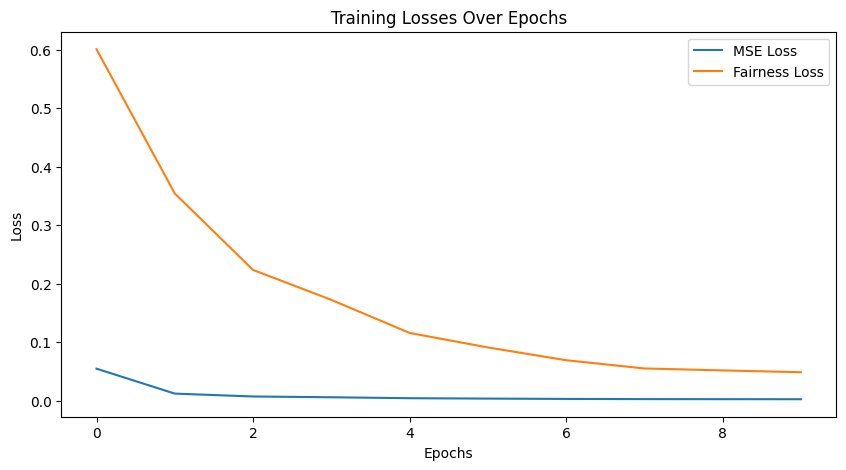

In [88]:
plt.figure(figsize=(10, 5))
plt.plot(mse_losses, label='MSE Loss')
plt.plot(fairness_losses, label='Fairness Loss')
plt.title('Training Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Assuming `losses` is the dictionary containing your loss data
alphas = [5, 50, 100]
num_epochs = 15

# Create a plot for MSE losses
plt.figure(figsize=(10, 5))
for alpha in alphas:
    plt.plot(losses[alpha]['mse'], label=f'Alpha {alpha}')
plt.title('MSE Loss Across Different Alphas')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# Create a plot for Fairness losses
plt.figure(figsize=(10, 5))
for alpha in alphas:
    plt.plot(losses[alpha]['fairness'], label=f'Alpha {alpha}')
plt.title('Fairness Loss Across Different Alphas')
plt.xlabel('Epoch')
plt.ylabel('Fairness Loss')
plt.legend()
plt.grid(True)
plt.show()


# testing

In [20]:
autoencoder = AutoEncoder([6018, 100, 6018], use_batch_norm=True)  #100 neurons, so it should be 100 in the hidden layer, but got error, so adjust 50 to 100
autoencoder.load_state_dict(torch.load('autoencoder.pth'))
dist_gen = DistributionGenerator(1, 6018)  # Input dimension and output dimension, 1 based on paper
dist_gen.load_state_dict(torch.load('dist_gen.pth'))

ae_optimizer = optim.Adam(autoencoder.parameters(), lr=0.005)
dg_optimizer = optim.Adam(dist_gen.parameters(), lr=0.005)

batch_size = 50
num_epochs = 10
args_max_pos_num = 1000
#alpha = 200

mse_losses = []
fairness_losses = []

autoencoder.eval()
dist_gen.eval()

for epoch in range(num_epochs):
    epoch_mse_losses = []
    epoch_fairness_losses = []
    for inputs, targets in test_loader:
        #autoencoder side
        reconstructed = autoencoder(inputs)  
        mse_loss = torch.nn.functional.mse_loss(reconstructed, inputs) 
        reg_loss = autoencoder.get_regularization_loss()


        # Distribution generator side
        random_seed = torch.randn((args_max_pos_num, 1))
        P = dist_gen(random_seed)
        mask = calculate_mmd_mask(reconstructed, inputs)
        dg_loss = selective_mmd_loss(P, inputs.mean(dim=0, keepdim=True), mask)
        
        #combine losses
        fairness_loss = dg_loss
        total_loss = mse_loss + 0.00001 * reg_loss + fairness_loss #previous ae_loss
        
        total_loss.backward()
        ae_optimizer.step()
        ae_optimizer.zero_grad()
        
        epoch_mse_losses.append(mse_loss.item())
        epoch_fairness_losses.append(fairness_loss.item())
        
    mse_losses.append(sum(epoch_mse_losses) / len(epoch_mse_losses))
    fairness_losses.append(sum(epoch_fairness_losses) / len(epoch_fairness_losses))
    print(f'Epoch {epoch+1}, Average MSE Loss: {mse_losses[-1]}, Average Fairness Loss: {fairness_losses[-1]}')

        
        

    print(f'Epoch {epoch+1}, MSE Loss: {mse_loss.item()}, Fairness Loss: {fairness_loss.item()}')




Epoch 1, Average MSE Loss: 0.01680698640430804, Average Fairness Loss: 0.25413257384397947
Epoch 1, MSE Loss: 0.002929394831880927, Fairness Loss: 0.07696766406297684
Epoch 2, Average MSE Loss: 0.001634926832907024, Average Fairness Loss: 0.02819187767406712
Epoch 2, MSE Loss: 0.0009310755413025618, Fairness Loss: 0.00544276786968112
Epoch 3, Average MSE Loss: 0.0010104828407285643, Average Fairness Loss: 0.009707445836030558
Epoch 3, MSE Loss: 0.0009667584090493619, Fairness Loss: 0.009638825431466103
Epoch 4, Average MSE Loss: 0.0006715437806722876, Average Fairness Loss: 0.003528085217589787
Epoch 4, MSE Loss: 0.0006403435254469514, Fairness Loss: 0.002251493511721492
Epoch 5, Average MSE Loss: 0.0004768308879975535, Average Fairness Loss: 0.0013768211785764968
Epoch 5, MSE Loss: 0.0004824814386665821, Fairness Loss: 0.0005194852710701525
Epoch 6, Average MSE Loss: 0.000372716586380342, Average Fairness Loss: 0.0007011772896312025
Epoch 6, MSE Loss: 0.0003923016192857176, Fairness L

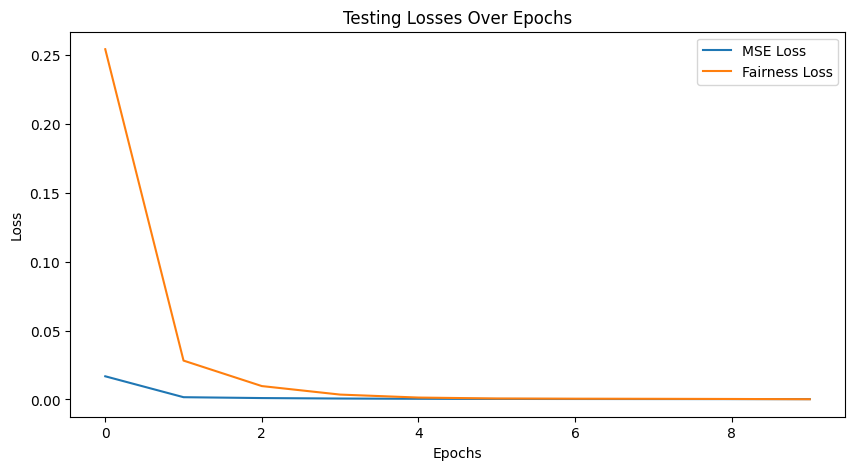

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(mse_losses, label='MSE Loss')
plt.plot(fairness_losses, label='Fairness Loss')
plt.title('Testing Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# evaluation
## NCDG: user view utility

In [34]:
k=15
def compute_precision_recall_ndcg(preds, truths, k):
    batch_size, num_items = preds.shape
    _, indices = torch.topk(preds, k, dim=1)  # Get indices of top-k predictions
    relevant = torch.zeros_like(preds, dtype=torch.float).scatter_(1, indices, 1)  # Mark top-k predictions
    
    hits = (relevant * truths).sum(dim=1)  # Calculate hits by element-wise multiplication and summing over items
    precision = hits.sum().item() / (k * batch_size)  # Total hits / (k * number of users)
    recall = hits.sum().item() / truths.sum().item()  # Total hits / total true interactions

    # NDCG calculation
    ndcg = 0
    for i in range(batch_size):
        sorted_scores = preds[i, indices[i]]
        true_labels = truths[i, indices[i]]
        idcg = (1 / torch.log2(torch.arange(2, k+2).float())).sum()
        dcg = (true_labels / torch.log2(torch.arange(2, k+2).float())).sum()
        ndcg += (dcg / idcg)

    ndcg /= batch_size

    return precision, recall, ndcg

with torch.no_grad():
    precisions = []
    recalls = []
    ndcgs = []
    for inputs, targets in test_loader:
        reconstructed = autoencoder(inputs)
        precision, recall, ndcg = compute_precision_recall_ndcg(reconstructed, targets, k)
        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)

    avg_precision = sum(precisions) / len(precisions)
    avg_recall = sum(recalls) / len(recalls)
    avg_ndcg = sum(ndcgs) / len(ndcgs)

    print(f'Average Precision@{k}: {avg_precision}')
    #print(f'Average Recall@{k}: {avg_recall}')
    print(f'Average NDCG@{k}: {avg_ndcg}')


Average Precision@15: 0.8756846898628425
Average NDCG@15: 0.8843587040901184


## mdg min & max

In [36]:
import torch
import numpy as np

def compute_metrics_and_mdg(preds, truths, k):
    batch_size, num_items = preds.shape
    _, indices = torch.topk(preds, k, dim=1)
    relevant = torch.zeros_like(preds, dtype=torch.float).scatter_(1, indices, 1)

    mdgs = []

    # Calculate MDG for each item
    for i in range(batch_size):
        user_mdgs = []
        for rank, index in enumerate(indices[i]):
            if truths[i, index] == 1:
                mdg = 1 / np.log2(1 + rank + 1)
                user_mdgs.append(mdg)
            else:
                user_mdgs.append(0)
        
        mdgs.append(np.mean(user_mdgs) if user_mdgs else 0)

    return np.mean(mdgs), mdgs


mdg_values = []
with torch.no_grad():
    for inputs, targets in test_loader:
        reconstructed = autoencoder(inputs)
        avg_mdg, item_mdgs = compute_metrics_and_mdg(reconstructed, targets, k)
        mdg_values.extend(item_mdgs) 

# Calculate MDG-min10% and MDG-max10%
mdg_values = np.array(mdg_values)
print(f"mdg values top 10 {mdg_values}")
nonzero_mdgs = np.count_nonzero(mdg_values)
print(f"Number of non-zero MDG values: {nonzero_mdgs} out of {len(mdg_values)}")

tenth_percentile_index = int(len(mdg_values) * 0.1)
mdg_min10 = np.mean(np.sort(mdg_values)[:tenth_percentile_index])
mdg_max10 = np.mean(np.sort(mdg_values)[-tenth_percentile_index:])

print(f"MDG-min10%: {mdg_min10}")
print(f"MDG-max10%: {mdg_max10}")


mdg values top 10 [0. 0. 0. ... 0. 0. 0.]
Number of non-zero MDG values: 0 out of 3018
MDG-min10%: 0.0
MDG-max10%: 0.0


## distribution of debugging

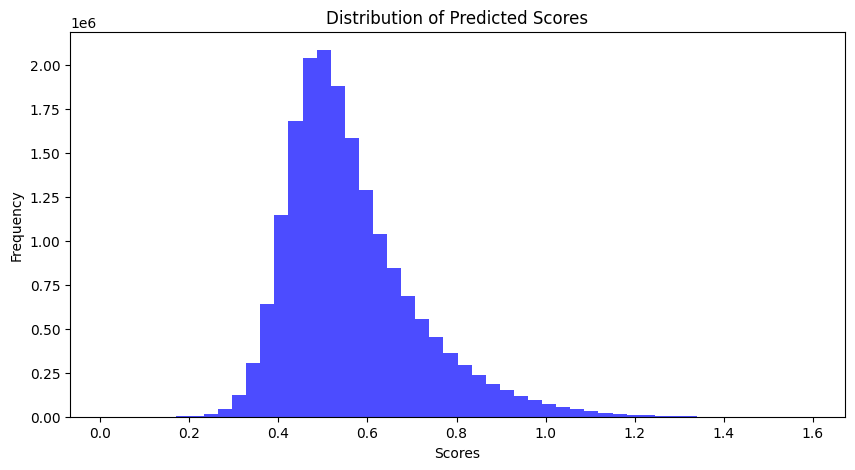

In [37]:
scores = []
with torch.no_grad():
    for inputs, _ in test_loader:
        reconstructed = autoencoder(inputs)
        scores.extend(reconstructed.flatten().tolist())

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(scores, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Predicted Scores')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.show()
